In [8]:
import numpy as np
import matplotlib.pyplot as plt

from stacked_mnist import StackedMNISTData, DataMode
from models.auto_encoder import AutoEncoder
from models.mnist_classifier import MNISTClassifier

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

from utils import *

In [9]:
# Using the provided mnist dataset class
gen = StackedMNISTData(mode=DataMode.COLOR_BINARY_COMPLETE, default_batch_size=9)

train_data = gen.get_full_data_set(training=True)
test_data = gen.get_full_data_set(training=False)

In [10]:
train_data[0].shape, test_data[0].shape

((60000, 28, 28, 3), (10000, 28, 28, 3))

In [51]:
y_train_x = train_data
_, ls = y_train_x
min_l = ls.where(ls.min())

AttributeError: 'numpy.ndarray' object has no attribute 'where'

(60000, 28, 28, 3) (60000,)
(10000, 28, 28, 3) (10000,)
(28, 28, 3)
561


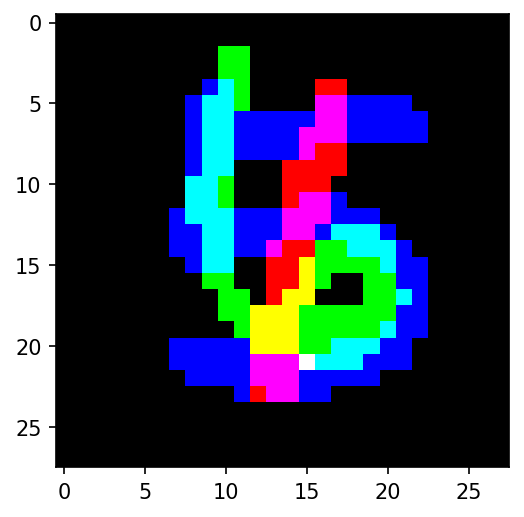

In [23]:
x_train, y_train = train_data
x_test, y_test = test_data
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Convert y_train and y_test into one-hot vectors
y_train = to_one_hot_rgb(y_train)
y_test = to_one_hot_rgb(y_test)

rand = np.random.randint(0, x_train.shape[0])
img = x_train[rand]
label = y_train[rand]
print(img.shape)

print(label.argmax())
plt.figure(figsize=(6, 4), dpi=150)
plt.imshow(255 * img)
plt.show()

In [24]:
# Create pytorch dataloaders from x_train and y_train
x_train = torch.from_numpy(x_train.astype(np.float32)).permute(0, 3, 1, 2)
y_train = torch.from_numpy(y_train.astype(np.float32))

train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)

# Create pytorch dataloaders from x_test and y_test
x_test = torch.from_numpy(x_test.astype(np.float32)).permute(0, 3, 1, 2)
y_test = torch.from_numpy(y_test.astype(np.float32))

test_dataset = TensorDataset(x_test, y_test)
test_loader = DataLoader(dataset=test_dataset, batch_size=32)

In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [26]:
# Training setup
model = AutoEncoder(in_channels=3)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
criterion = nn.BCELoss()

# Training the autoencoder
val_losses = []

for epoch in range(100):
    model.train()
    total_loss = 0
    for images, _ in train_loader:
        images = images.to(device)
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, images)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch: {epoch}, Loss: {total_loss / len(train_loader)}")

    # Test on test data
    model.eval()
    test_loss_sum = 0
    with torch.no_grad():
        for images, _ in test_loader:
            images = images.to(device)
            output = model(images)
            loss = criterion(output, images)
            test_loss_sum += loss.item()
        
        test_loss = test_loss_sum / len(test_loader)
        print(f"Test Loss: {test_loss}")
        if (len(val_losses) > 5) and all(test_loss >= x for x in val_losses[-3:]):
            print("Early Stopping...")
            break
        val_losses.append(test_loss)


Epoch: 0, Loss: 0.2642312916676203
Test Loss: 0.23870935069676785
Epoch: 1, Loss: 0.22994717054367064
Test Loss: 0.22393267566022781
Epoch: 2, Loss: 0.2134972075064977
Test Loss: 0.1990955982821437
Epoch: 3, Loss: 0.1927721044143041
Test Loss: 0.18741123225932685
Epoch: 4, Loss: 0.18492922183672586
Test Loss: 0.18232055441640055
Epoch: 5, Loss: 0.1815139303445816
Test Loss: 0.17988960625835881
Epoch: 6, Loss: 0.17948444347381592
Test Loss: 0.17822096365899703
Epoch: 7, Loss: 0.1780569242397944
Test Loss: 0.17707044433671446
Epoch: 8, Loss: 0.17537842214107513
Test Loss: 0.17157643333601114
Epoch: 9, Loss: 0.1702022030989329
Test Loss: 0.16856747946609704
Epoch: 10, Loss: 0.16750288535753885
Test Loss: 0.16609308594903247
Epoch: 11, Loss: 0.16524176667531332
Test Loss: 0.16412478280714907
Epoch: 12, Loss: 0.16317816174030303
Test Loss: 0.16225772577162367
Epoch: 13, Loss: 0.1612313634634018
Test Loss: 0.16064627292438055
Epoch: 14, Loss: 0.1591537695010503
Test Loss: 0.15928684117885444

In [28]:
# Save the AutoEncoder model
torch.save(model.state_dict(), "trained_models/auto_encoder_rgb.pt")

In [27]:
# Test the auto encoder
model.eval()

test_loss = 0

with torch.no_grad():
    for x, _ in test_loader:
        x = x.to(device)
        pred = model(x)
        loss = criterion(pred, x)
        test_loss += loss.item()

print(f"Test Loss: {test_loss / len(test_loader)}")

Test Loss: 0.1303422874964464


In [29]:
mnist_classifier = MNISTClassifier(1)
mnist_classifier.load_state_dict(torch.load('trained_models/mnist_model.pt'))

<All keys matched successfully>

In [30]:
mnist_classifier.to(device)

MNISTClassifier(
  (feature_extractor): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3136, out_features=128, bias=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=10, bias=True)
  )
)

In [53]:
correct_preds = 0

with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        y = y.to(device)
        ae_output = model(x)

        correct_preds 
        ae_output_class_r = mnist_classifier(ae_output[:, 0, :, :].unsqueeze(1))
        ae_output_class_g = mnist_classifier(ae_output[:, 1, :, :].unsqueeze(1))
        ae_output_class_b = mnist_classifier(ae_output[:, 2, :, :].unsqueeze(1))
        ae_output_class_r = ae_output_class_r.argmax(dim=1, keepdim=True)
        ae_output_class_g = ae_output_class_g.argmax(dim=1, keepdim=True)
        ae_output_class_b = ae_output_class_b.argmax(dim=1, keepdim=True)

        truth = y.argmax(dim=1, keepdim=True)
        for i, batch in enumerate(truth):
            number = batch.item()
            if len(str(number)) == 3:
                b, g, r = [int(n) for n in str(number)]
            elif len(str(number)) == 2:
                b = 0
                g, r = [int(n) for n in str(number)]
            elif len(str(number)) == 1:
                b = 0
                g = 0
                r = [int(n) for n in str(number)]
            b_pred = ae_output_class_b[i].item()
            g_pred = ae_output_class_g[i].item()
            r_pred = ae_output_class_r[i].item()

            if (b == b_pred) and (r == r_pred) and (g == g_pred):
                correct_preds += 1
    

    accuracy = correct_preds / len(test_loader.dataset)

print(f"Accuracy: {100*accuracy}%")

Accuracy: 59.79%


Some analysis of latent states from encoded images

In [54]:
rand = np.random.randint(0, 31)
rand

0

In [55]:
with torch.no_grad():
    i, (x, y) = next(enumerate(test_loader))
    x = x.to(device)
    y = y.to(device)
    latent_state = model.encoder(x)

latent_state.shape

torch.Size([32, 16])

In [56]:
latent_state = latent_state[rand].squeeze().cpu().numpy()
latent_state.shape

(16,)

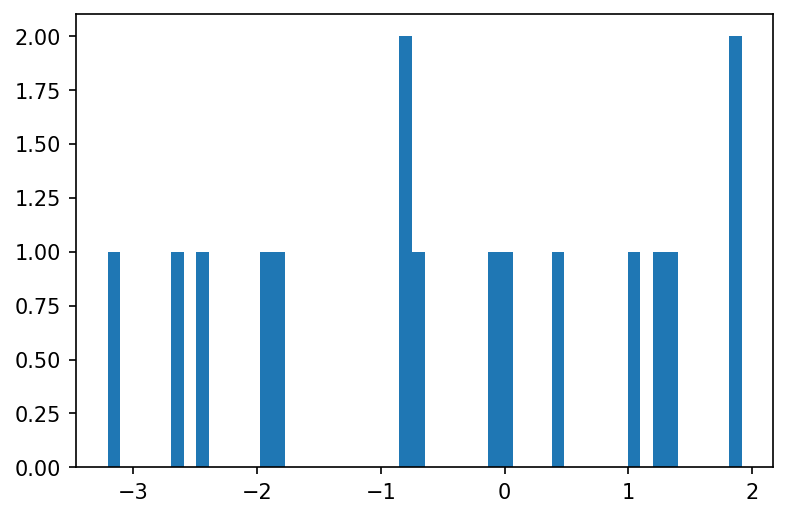

In [57]:
plt.figure(figsize=(6, 4), dpi=150)
plt.hist(latent_state, bins=50)
plt.show()